### INITIAL DATA VIEW

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

csv_path = "./ccl_raw_sales_data_daily.csv"

# Load data
df = pd.read_csv(csv_path,
                 parse_dates=['date'],
                 dayfirst=False,
                 infer_datetime_format=True)

# Sort date, clean headers
df.sort_values(by='date', inplace=True)
df.columns = [col.lower() for col in df.columns]

numeric_cols = [
    'lf_imprs', 'mf_imprs', 'uf_imprs', 'lf_clicks', 'mf_clicks', 'uf_clicks',
    'lf_lands', 'mf_lands', 'uf_lands', 'lf_kpv', 'mf_kpv', 'uf_kpv',
    'lf_sales', 'mf_sales', 'uf_sales', 'total_imprs', 'total_clicks',
    'total_lands', 'total_kpv', 'total_sales'
]

# Convert numeric columns
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

fill_zero_cols = [
    'lf_imprs', 'mf_imprs', 'uf_imprs', 'lf_clicks', 'mf_clicks', 'uf_clicks',
    'lf_lands', 'mf_lands', 'uf_lands', 'lf_kpv', 'mf_kpv', 'uf_kpv',
    'lf_sales', 'mf_sales', 'uf_sales', 'total_imprs', 'total_clicks',
    'total_sales'
]

# Fill missing data with 0 for now
for col in fill_zero_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Drop duplicates
df.drop_duplicates(subset=['date', 'channel'], keep='first', inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)

df.head()

In [ ]:
def create_time_aggregates(df: pd.DataFrame) -> tuple:
    metrics = ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv', 'total_sales']

    df_indexed = df.set_index('date')

    daily_overall = df.groupby('date')[metrics].sum().reset_index()
    weekly_overall = df_indexed[metrics].resample('W').sum().reset_index()
    monthly_overall = df_indexed[metrics].resample('M').sum().reset_index()

    daily_by_channel = df.groupby(['date',
                                   'channel'])[metrics].sum().reset_index()
    weekly_by_channel = (df_indexed.groupby('channel')[metrics].resample(
        'W').sum().reset_index())
    monthly_by_channel = (df_indexed.groupby('channel')[metrics].resample(
        'M').sum().reset_index())

    return (daily_overall, weekly_overall, monthly_overall, daily_by_channel,
            weekly_by_channel, monthly_by_channel)


def plot_time_series(data: pd.DataFrame,
                     title: str,
                     metrics: List[str],
                     normalize: bool = True):
    plt.figure(figsize=(15, 8))

    for metric in metrics:
        values = data[metric]
        if normalize:
            values = values / values.max()
        plt.plot(data['date'], values, label=metric)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Normalized Values" if normalize else "Raw Values")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(data: pd.DataFrame, title: str,
                             metrics: List[str]):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data[metrics].corr()
    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                center=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_channel_comparison(data: pd.DataFrame, metric: str, period: str):
    plt.figure(figsize=(15, 8))

    for channel in data['channel'].unique():
        channel_data = data[data['channel'] == channel]
        plt.plot(channel_data['date'], channel_data[metric], label=channel)

    plt.title(f"{metric} by Channel ({period})")
    plt.xlabel("Date")
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def main():
    df = pd.read_csv("./ccl_raw_sales_data_daily.csv", parse_dates=['date'])

    metrics = ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv', 'total_sales']

    (daily_overall, weekly_overall, monthly_overall, daily_by_channel,
     weekly_by_channel, monthly_by_channel) = create_time_aggregates(df)

    plot_time_series(daily_overall, "Daily Metrics (All Channels)", metrics)
    plot_time_series(weekly_overall, "Weekly Metrics (All Channels)", metrics)
    plot_time_series(monthly_overall, "Monthly Metrics (All Channels)",
                     metrics)

    plot_correlation_heatmap(daily_overall, "Daily Correlations", metrics)
    plot_correlation_heatmap(weekly_overall, "Weekly Correlations", metrics)
    plot_correlation_heatmap(monthly_overall, "Monthly Correlations", metrics)

    for metric in metrics:
        plot_channel_comparison(monthly_by_channel, metric, "Monthly")
        plot_channel_comparison(weekly_by_channel, metric, "Weekly")

    print("\nMonthly Correlations with Total Sales:")
    for channel in df['channel'].unique():
        channel_data = monthly_by_channel[monthly_by_channel['channel'] ==
                                          channel]
        correlations = channel_data[metrics].corr()['total_sales'].drop(
            'total_sales')
        print(f"\n{channel}:")
        for metric, corr in correlations.items():
            print(f"{metric}: {corr:.3f}")

    fig, axes = plt.subplots(len(metrics),
                             1,
                             figsize=(15, 4 * len(metrics)),
                             sharex=True)
    fig.suptitle("Monthly Metrics by Channel (Raw Values)")

    for i, metric in enumerate(metrics):
        for channel in df['channel'].unique():
            channel_data = monthly_by_channel[monthly_by_channel['channel'] ==
                                              channel]
            axes[i].plot(channel_data['date'],
                         channel_data[metric],
                         label=channel)
        axes[i].set_ylabel(metric)
        axes[i].grid(True)
        axes[i].legend()

    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

### UF METRICS VS. TOTAL SALES

Loading data...
Running analysis...


C:\Users\John.Arancio\AppData\Local\Temp\ipykernel_8772\838271889.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
C:\Users\John.Arancio\AppData\Local\Temp\ipykernel_8772\838271889.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['period_date'] = pd.to_datetime(df['period_date'])



Analyzing W frequency...

Integrated Causal Impact Analysis:

Metric Impact Analysis (20% Increase):

uf_imprs_lag4:
------------------------------
Random Forest Results:
Average Lift: 1.70%
Lift Range: -5.96% to 42.46%

OLS Regression Results:
Coefficient: 0.000
P-value: 0.0000
R-squared: 0.423

Elasticity Analysis:
Elasticity: 0.595
Standard Error: 0.078
T-statistic: 7.610
P-value: 0.0000
R-squared: 0.355

uf_lands:
------------------------------
Random Forest Results:
Average Lift: 0.40%
Lift Range: -1.50% to 25.37%

OLS Regression Results:
Coefficient: 0.269
P-value: 0.0000
R-squared: 0.503

Elasticity Analysis:
Elasticity: 0.380
Standard Error: 0.042
T-statistic: 8.945
P-value: 0.0000
R-squared: 0.432

Random Forest Feature Importance:
------------------------------
month: 0.421
quarter: 0.283
uf_imprs_lag4: 0.044
trend: 0.039
uf_lands: 0.021

Seasonal Impact Analysis for month:
------------------------------
quarter             
1        total_sales   -0.028043
2        total_sa

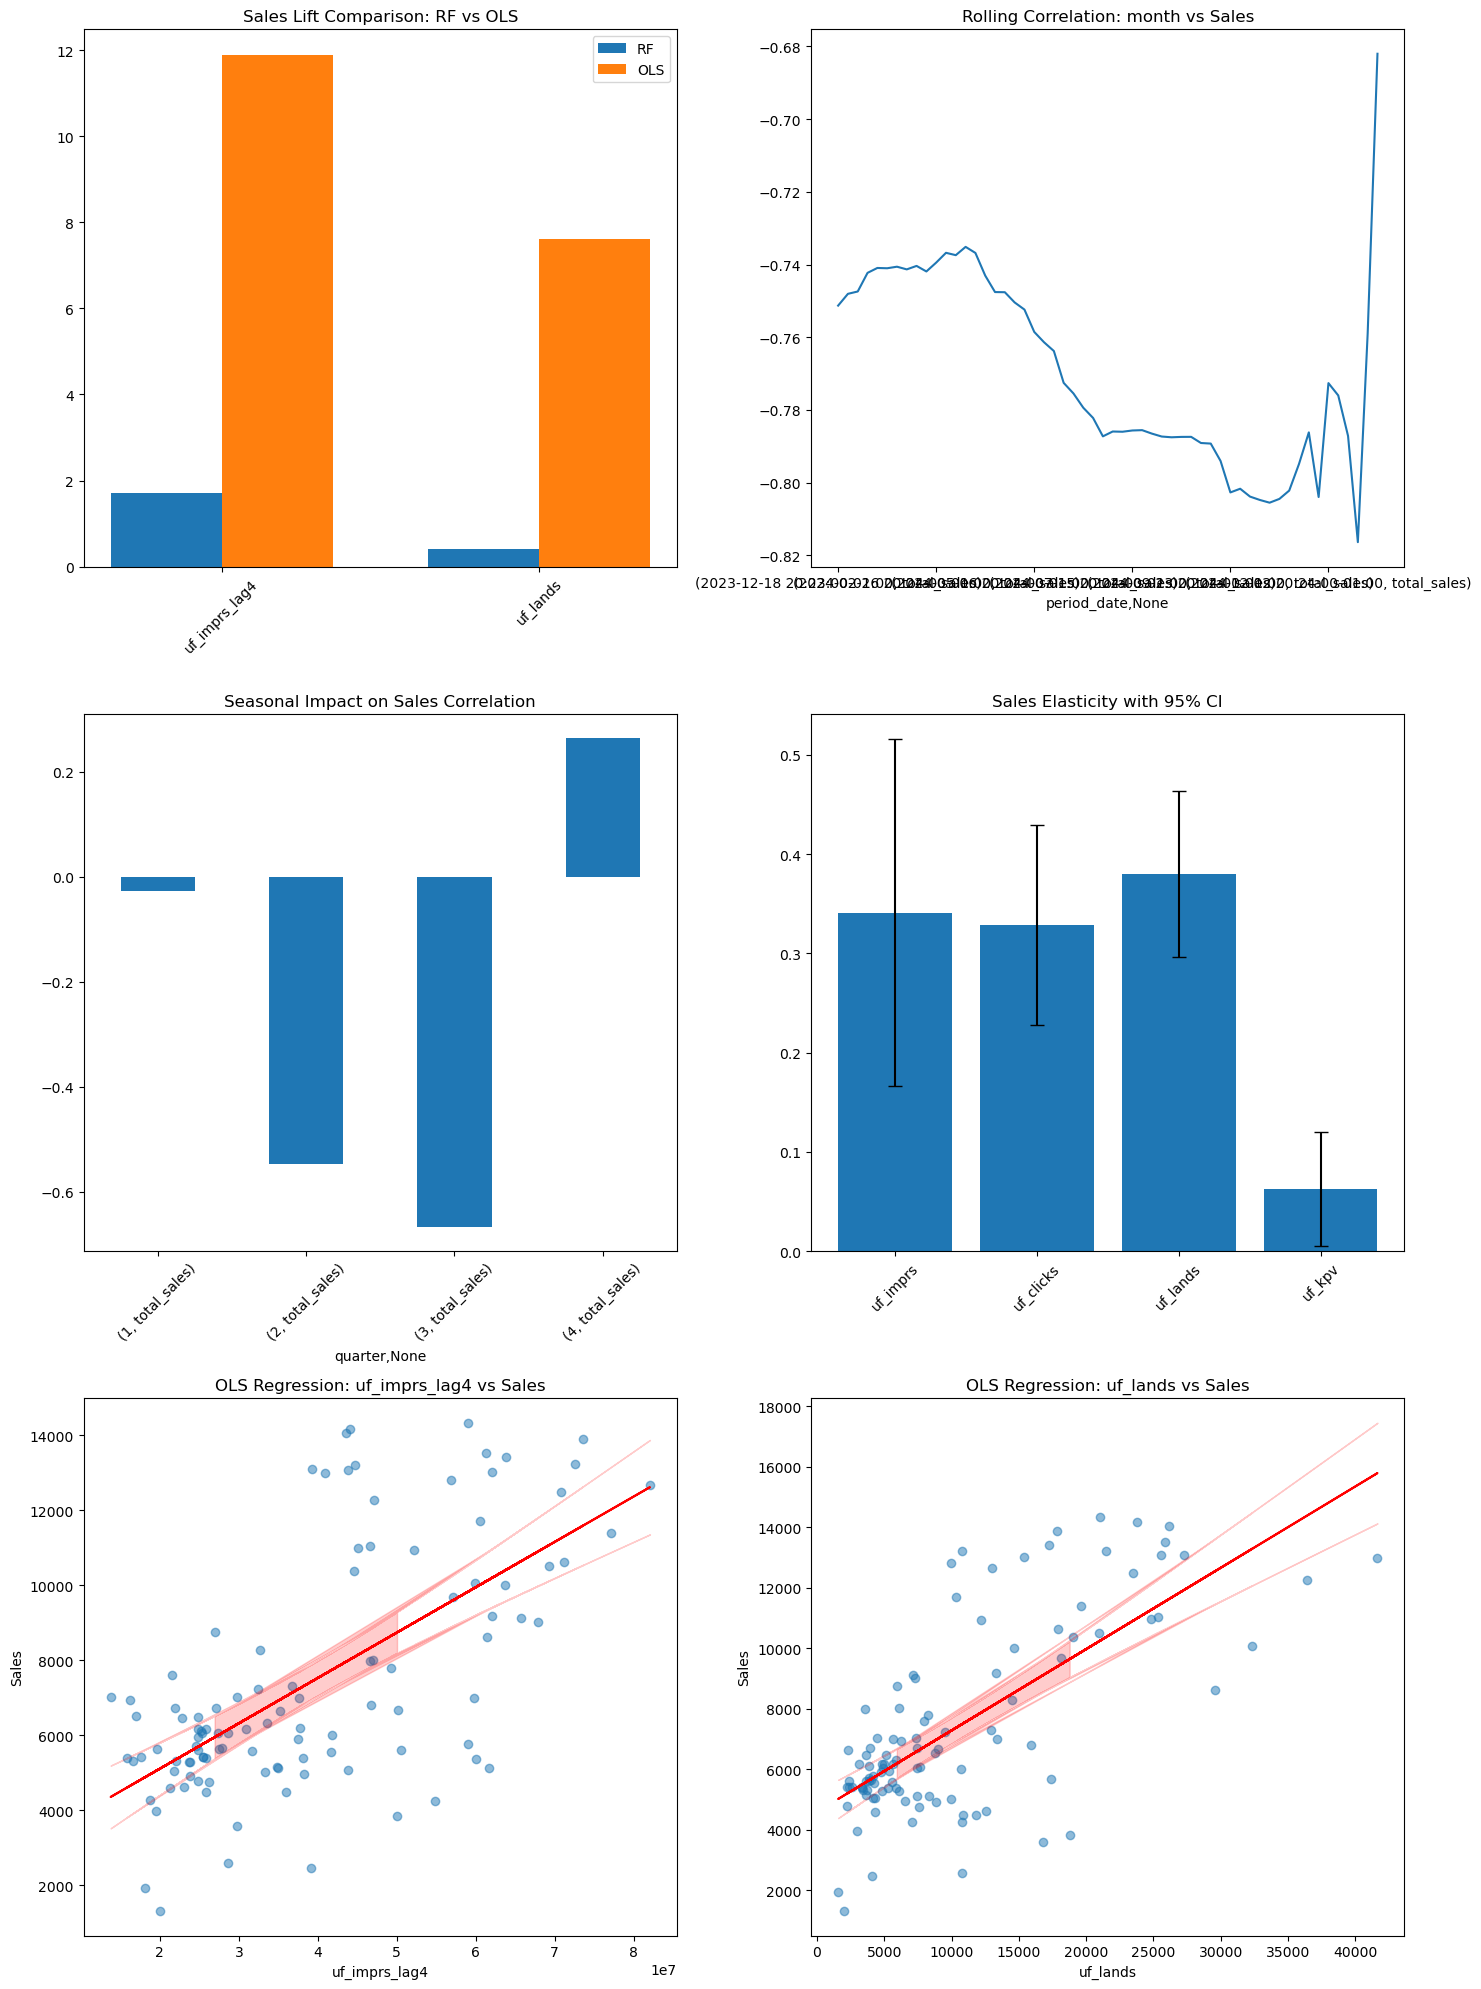


Analyzing M frequency...

Integrated Causal Impact Analysis:

Metric Impact Analysis (20% Increase):

uf_lands:
------------------------------
Random Forest Results:
Average Lift: 4.12%
Lift Range: -0.37% to 34.92%

OLS Regression Results:
Coefficient: 0.389
P-value: 0.0000
R-squared: 0.594

Elasticity Analysis:
Elasticity: 0.519
Standard Error: 0.135
T-statistic: 3.846
P-value: 0.0009
R-squared: 0.402

uf_imprs_lag2:
------------------------------
Random Forest Results:
Average Lift: 2.21%
Lift Range: -0.52% to 14.57%

OLS Regression Results:
Coefficient: 0.000
P-value: 0.0011
R-squared: 0.391

Elasticity Analysis:
Elasticity: 0.546
Standard Error: 0.251
T-statistic: 2.177
P-value: 0.0405
R-squared: 0.177

uf_imprs_lag1:
------------------------------
Random Forest Results:
Average Lift: 0.25%
Lift Range: -4.53% to 6.80%

OLS Regression Results:
Coefficient: 0.000
P-value: 0.0251
R-squared: 0.208

Elasticity Analysis:
Elasticity: 0.219
Standard Error: 0.261
T-statistic: 0.840
P-value

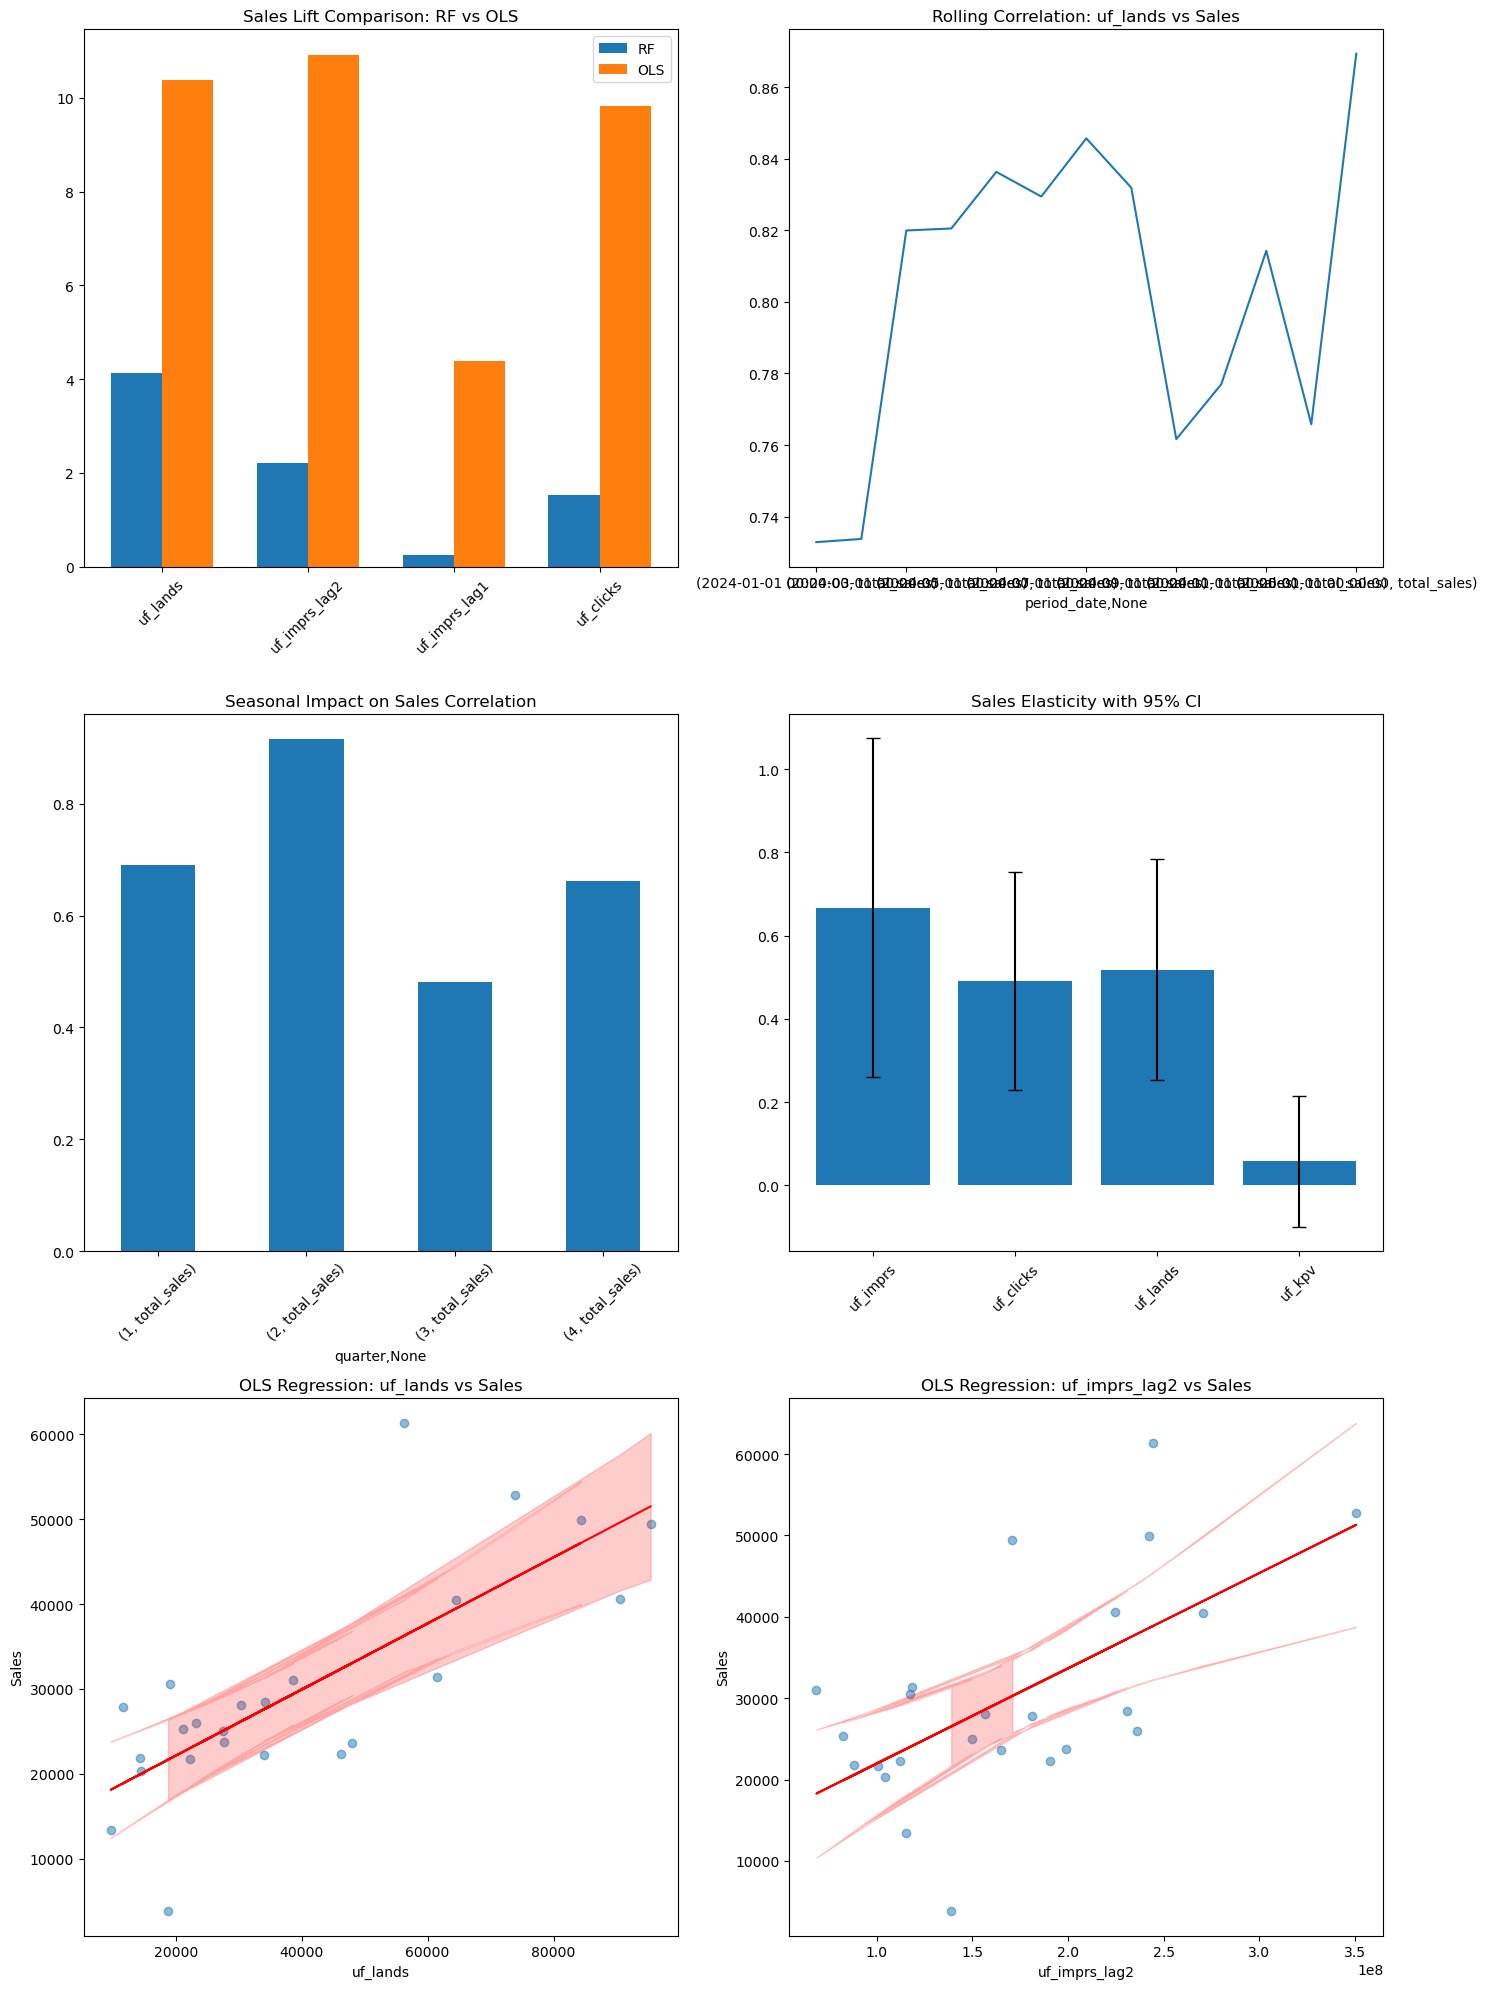

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def prepare_time_series_data(df, frequency='W'):
    """
    Prepare time series data for either weekly or monthly analysis
    """
    df['date'] = pd.to_datetime(df['date'])
    
    # monthly weekly group
    if frequency == 'M':
        df['period_date'] = df['date'].dt.to_period('M').astype(str) + '-01'
    else:
        df['period_date'] = df['date'].dt.to_period('W').astype(str) + '-1'
    
    df['period_date'] = pd.to_datetime(df['period_date'])
    
    # agg period
    agg_df = df.groupby(['period_date']).agg({
        'uf_imprs': 'sum',
        'uf_clicks': 'sum',
        'uf_lands': 'sum',
        'uf_kpv': 'sum',
        'total_sales': 'sum'
    }).reset_index()
    
    agg_df = agg_df.set_index('period_date')
    
    # lags
    metrics = ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv']
    lag_periods = 3 if frequency == 'M' else 4
    
    for metric in metrics:
        for lag in range(1, lag_periods + 1):
            agg_df[f'{metric}_lag{lag}'] = agg_df[metric].shift(lag)
        
        # rates
        if metric != 'uf_imprs':
            prev_metric = metrics[metrics.index(metric) - 1]
            agg_df[f'{metric}_rate'] = agg_df[metric] / agg_df[prev_metric].replace(0, np.nan)
    
    # seasonality features
    agg_df['month'] = agg_df.index.month
    agg_df['quarter'] = agg_df.index.quarter
    
    # trend
    agg_df['trend'] = np.arange(len(agg_df))
    agg_df = agg_df.dropna()
    
    return agg_df

def analyze_and_compare(df):
    """
    Analyze and compare weekly vs monthly patterns
    """
    results = {}
    
    for frequency in ['W', 'M']:

        prepared_df = prepare_time_series_data(df, frequency)
        
        # corrs
        correlations = prepared_df.corr()
        
        # RF
        rf_importance, rf_model = run_random_forest_analysis(prepared_df)
        
        # GC
        granger_results = {}
        for col in ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv']:
            try:
                granger = grangercausalitytests(
                    prepared_df[['total_sales', col]], 
                    maxlag=4, 
                    verbose=False
                )
                granger_results[col] = min([test[0]['ssr_chi2test'][1] 
                                          for test in granger.values()])
            except:
                granger_results[col] = np.nan
        
        # results
        results[frequency] = {
            'data': prepared_df,
            'correlations': correlations,
            'rf_importance': rf_importance,
            'rf_model': rf_model,
            'granger_causality': granger_results
        }
    
    return results

def run_random_forest_analysis(df):
    """
    Run Random Forest analysis and return feature importance
    """
    # x y split
    X = df.drop(['total_sales'], axis=1)
    y = df['total_sales']
    
    # fit RF
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # feat importance
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return importance, rf

def run_ols_analysis(df, metric):
    """
    Run OLS regression analysis for a given metric
    """
    # x y split
    X = df[metric]
    y = df['total_sales']
    X = sm.add_constant(X)
    
    # fit
    model = sm.OLS(y, X).fit()
    
    # pred values and CI
    predictions = model.predict(X)
    pred_ci = model.get_prediction(X).conf_int()
    
    return {
        'model': model,
        'predictions': predictions,
        'confidence_intervals': pred_ci,
        'summary': model.summary()
    }

def calculate_elasticity_with_inference(df, metric):
    """
    Calculate elasticity with additional statistical inference
    """
    # Log transformation -
    log_sales = np.log(df['total_sales'] + 1)
    log_metric = np.log(df[metric] + 1)
    
    # OLS for elastic
    X = sm.add_constant(log_metric)
    model = sm.OLS(log_sales, X).fit()
    
    # stats
    elasticity = model.params[1]
    std_err = model.bse[1]
    t_stat = model.tvalues[1]
    p_value = model.pvalues[1]
    r_squared = model.rsquared
    
    return {
        'elasticity': elasticity,
        'std_err': std_err,
        't_stat': t_stat,
        'p_value': p_value,
        'r_squared': r_squared,
        'model': model
    }

def run_causal_inference_analysis(df, results, frequency='W'):
    """
    Integrated causal inference analysis combining RF and OLS approaches
    """
    # RF top feats
    top_features = results[frequency]['rf_importance'].head(5)['feature'].tolist()
    
    # scenarios
    baseline_df = df.copy()
    scenarios = {}
    
    for feature in top_features:
        if feature in ['month', 'quarter', 'trend']:  # Skip non-UF metrics
            continue
            
        # Analysis
        # RF
        intervention_df = df.copy()
        intervention_df[feature] = intervention_df[feature] * 1.2
        
        baseline_pred = results[frequency]['rf_model'].predict(baseline_df.drop('total_sales', axis=1))
        intervention_pred = results[frequency]['rf_model'].predict(intervention_df.drop('total_sales', axis=1))
        
        rf_lift = (intervention_pred - baseline_pred) / baseline_pred * 100
        
        # OLS 
        ols_results = run_ols_analysis(df, feature)
        elasticity_results = calculate_elasticity_with_inference(df, feature)
        
        scenarios[feature] = {
            'rf_baseline': baseline_pred,
            'rf_intervention': intervention_pred,
            'rf_lift': rf_lift,
            'rf_avg_lift': np.mean(rf_lift),
            'ols_results': ols_results,
            'elasticity_results': elasticity_results
        }
    
    return scenarios

def analyze_temporal_patterns(df, metric, frequency='W'):
    """
    Analyze temporal patterns in the relationship between metric and sales
    """
    # rolling corrs
    window = 12 if frequency == 'M' else 52
    rolling_corr = df[['total_sales', metric]].rolling(window=window).corr()
    rolling_corr = rolling_corr.loc[(slice(None), 'total_sales'), metric]
    
    # seasonal patterns
    seasonal_df = df.groupby('quarter')[[metric, 'total_sales']].corr()
    seasonal_impact = seasonal_df.loc[(slice(None), 'total_sales'), metric]
    
    return {
        'rolling_correlation': rolling_corr,
        'seasonal_impact': seasonal_impact
    }

def plot_integrated_insights(results, scenarios, frequency='W'):
    """
    Create visualizations combining RF and OLS insights
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    
    # RF vs OLS Lifts
    rf_lifts = {k: v['rf_avg_lift'] for k, v in scenarios.items()}
    ols_lifts = {k: v['elasticity_results']['elasticity'] * 20 for k, v in scenarios.items()}  # 20% increase
    
    x = np.arange(len(rf_lifts))
    width = 0.35
    
    axes[0,0].bar(x - width/2, rf_lifts.values(), width, label='RF')
    axes[0,0].bar(x + width/2, ols_lifts.values(), width, label='OLS')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(rf_lifts.keys(), rotation=45)
    axes[0,0].set_title('Sales Lift Comparison: RF vs OLS')
    axes[0,0].legend()
    
    # Rolling Impact
    df = results[frequency]['data']
    top_metric = results[frequency]['rf_importance'].iloc[0]['feature']
    temporal = analyze_temporal_patterns(df, top_metric, frequency)
    temporal['rolling_correlation'].dropna().plot(ax=axes[0,1])
    axes[0,1].set_title(f'Rolling Correlation: {top_metric} vs Sales')
    
    # Seasonal patterns
    temporal['seasonal_impact'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Seasonal Impact on Sales Correlation')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # CI elastic
    elasticities = {}
    conf_intervals = {}
    
    for metric in ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv']:
        try:
            results = calculate_elasticity_with_inference(df, metric)
            elasticities[metric] = results['elasticity']
            conf_intervals[metric] = [
                results['elasticity'] - 1.96 * results['std_err'],
                results['elasticity'] + 1.96 * results['std_err']
            ]
        except:
            elasticities[metric] = np.nan
            conf_intervals[metric] = [np.nan, np.nan]
    
    metrics = list(elasticities.keys())
    values = list(elasticities.values())
    errors = [
        [v - conf_intervals[m][0] for m, v in elasticities.items()],
        [conf_intervals[m][1] - v for m, v in elasticities.items()]
    ]
    
    axes[1,1].bar(metrics, values)
    axes[1,1].errorbar(metrics, values, yerr=errors, fmt='none', color='black', capsize=5)
    axes[1,1].set_title('Sales Elasticity with 95% CI')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # OLS reg plots top 2
    top_metrics = list(rf_lifts.keys())[:2]
    for i, metric in enumerate(top_metrics):
        try:
            ols_results = scenarios[metric]['ols_results']
            axes[2,i].scatter(df[metric], df['total_sales'], alpha=0.5)
            axes[2,i].plot(df[metric], ols_results['predictions'], color='red')
            axes[2,i].fill_between(
                df[metric],
                ols_results['confidence_intervals'][:,0],
                ols_results['confidence_intervals'][:,1],
                alpha=0.2, color='red'
            )
            axes[2,i].set_title(f'OLS Regression: {metric} vs Sales')
            axes[2,i].set_xlabel(metric)
            axes[2,i].set_ylabel('Sales')
        except Exception as e:
            axes[2,i].text(0.5, 0.5, f'Unable to plot OLS for {metric}\n{str(e)}',
                          ha='center', va='center')
    
    plt.tight_layout()
    return fig

def print_integrated_insights(scenarios, results, frequency='W'):
    """
    Print detailed insights combining RF and OLS results
    """
    print("\nIntegrated Causal Impact Analysis:")
    print("=" * 50)
    
    # RF and OLS results
    print("\nMetric Impact Analysis (20% Increase):")
    for metric, scenario in scenarios.items():
        print(f"\n{metric}:")
        print("-" * 30)
        
        # RF 
        print("Random Forest Results:")
        print(f"Average Lift: {scenario['rf_avg_lift']:.2f}%")
        print(f"Lift Range: {np.min(scenario['rf_lift']):.2f}% to {np.max(scenario['rf_lift']):.2f}%")
        
        # OLS 
        print("\nOLS Regression Results:")
        ols_model = scenario['ols_results']['model']
        print(f"Coefficient: {ols_model.params[1]:.3f}")
        print(f"P-value: {ols_model.pvalues[1]:.4f}")
        print(f"R-squared: {ols_model.rsquared:.3f}")
        
        # Elasticity 
        elasticity = scenario['elasticity_results']
        print("\nElasticity Analysis:")
        print(f"Elasticity: {elasticity['elasticity']:.3f}")
        print(f"Standard Error: {elasticity['std_err']:.3f}")
        print(f"T-statistic: {elasticity['t_stat']:.3f}")
        print(f"P-value: {elasticity['p_value']:.4f}")
        print(f"R-squared: {elasticity['r_squared']:.3f}")
    
    # RF feat importance
    print("\nRandom Forest Feature Importance:")
    print("-" * 30)
    for _, row in results[frequency]['rf_importance'].head().iterrows():
        print(f"{row['feature']}: {row['importance']:.3f}")
    
    # Temporal stats
    try:
        top_metric = results[frequency]['rf_importance'].iloc[0]['feature']
        temporal = analyze_temporal_patterns(results[frequency]['data'], top_metric, frequency)
        print(f"\nSeasonal Impact Analysis for {top_metric}:")
        print("-" * 30)
        print(temporal['seasonal_impact'])
    except Exception as e:
        print(f"\nUnable to calculate temporal patterns: {str(e)}")

def summarize_integrated_evidence(results, scenarios, frequency='W'):
    """
    Provide comprehensive summary of all evidence
    """
    print(f"\nComprehensive Analysis Summary ({frequency}):")
    print("=" * 50)
    
    # Compare models
    print("\n1. Model Performance Comparison:")
    for metric, scenario in scenarios.items():
        rf_rmse = np.sqrt(np.mean((scenario['rf_baseline'] - results[frequency]['data']['total_sales'])**2))
        ols_rmse = np.sqrt(np.mean((scenario['ols_results']['predictions'] - results[frequency]['data']['total_sales'])**2))
        
        print(f"\n{metric}:")
        print(f"RF RMSE: {rf_rmse:.2f}")
        print(f"OLS RMSE: {ols_rmse:.2f}")
        print(f"RF R-squared: {results[frequency]['rf_model'].score(results[frequency]['data'].drop('total_sales', axis=1), results[frequency]['data']['total_sales']):.3f}")
        print(f"OLS R-squared: {scenario['ols_results']['model'].rsquared:.3f}")
    
    # Causality Evidence
    print("\n2. Causality Evidence:")
    for metric, scenario in scenarios.items():
        print(f"\n{metric}:")
        # Granger causality
        granger_p = results[frequency]['granger_causality'].get(metric, np.nan)
        print(f"Granger Causality p-value: {granger_p:.4f}")
        # OLS significance
        ols_p = scenario['ols_results']['model'].pvalues[1]
        print(f"OLS p-value: {ols_p:.4f}")
        # Combined
        if granger_p < 0.05 and ols_p < 0.05:
            strength = "Strong"
        elif granger_p < 0.05 or ols_p < 0.05:
            strength = "Moderate"
        else:
            strength = "Weak"
        print(f"Causal Evidence Strength: {strength}")
    
    # Impact Estimates
    print("\n3. Impact Estimates (20% Increase):")
    for metric, scenario in scenarios.items():
        print(f"\n{metric}:")
        print(f"RF Estimate: {scenario['rf_avg_lift']:.2f}%")
        print(f"OLS Estimate: {scenario['elasticity_results']['elasticity'] * 20:.2f}%")
        
        # Confidence 
        rf_std = np.std(scenario['rf_lift'])
        ols_std = scenario['elasticity_results']['std_err'] * 20
        print(f"RF Uncertainty: ±{rf_std:.2f}%")
        print(f"OLS Uncertainty: ±{ols_std:.2f}%")

def main():
    """
    Main execution function
    """
    # Load data
    print("Loading data...")
    df = pd.read_csv("ccl_raw_sales_data_daily.csv")
    
    # Run
    print("Running analysis...")
    results = analyze_and_compare(df)
    for freq in ['W', 'M']:
        print(f"\nAnalyzing {freq} frequency...")
        prepared_df = results[freq]['data']
        scenarios = run_causal_inference_analysis(prepared_df, results, freq)
        results[freq]['scenarios'] = scenarios
        
        # stats
        print_integrated_insights(scenarios, results, freq)
        summarize_integrated_evidence(results, scenarios, freq)
        
        # plots
        fig = plot_integrated_insights(results, scenarios, freq)
        plt.show()
    
    return results

if __name__ == "__main__":
    results = main()


# Upper Funnel Impact On Sales

## Overview
Investigated the relationship between upper funnel metrics (e.g., impressions, clicks, lands) and total sales using a combination of Random Forest (RF) and Ordinary Least Squares (OLS) regression modeling. Analyses were conducted at both weekly and monthly cadences to capture short-term (weekly) and medium-term (monthly) variations. Where applicable, lagged variables (e.g., a 4-week lag of impressions) were introduced to test delayed impacts on sales.

## Methodology
- Data preparation: Aggregated daily data to weekly and monthly frequencies
- Feature engineering: Lag features (e.g., impressions from 4 weeks or 2 months prior) were created to assess delayed effects on sales + seasonal indicators and trend variables
- Analysis methods: A non-linear model (Random Forest (RF) for capturing complex interactions, a linear approach (OLS Regression) offering model interpretability through coefficients and p-values, then granger causality used to explore whether one time series can help predict future values of another (i.e., causal signals).
- Validation: Cross-comparison between RF and OLS results using R-squared, RMSE, and feature importance to understand which metrics best explain fluctuations in total sales.

## Weekly Analysis Results

### Key Findings
1. **Feature Importance**
   - Month: 42.1%
   - Quarter: 28.3%
   - Impressions (4-week lag): 4.4%
   - Trend: 3.9%
   - Lands: 2.1%
   
    *Excluding seasonality trends (i.e. Month/Quarter) upper funnel metrics, such as 4-week lagged impressions (4.4%) and lands (2.1%), still contributed noteworthy predictor power.*

<br>

2. **Impact Sale Estimates (20% increase in correlated metrics)**
   
   - Impressions (4-week lag):
     * RF Estimate: 1.70% average lift (±6.73%)
     * OLS Estimate: 11.89% average lift (±1.56%)
     
    *Suggests that boosting impressions may have a modest immediate effect per the RF but a potentially larger, more direct effect as indicated by the OLS coefficient.*

   - Lands:
     * RF Estimate: 0.40% average lift (±2.54%)
     * OLS Estimate: 7.60% average lift (±0.85%)

    *Implies that getting more lands from the upper funnel can push sales upward, although estimates differ by model.*

<br>

3. **Model Performance**
   - RF r^2: 0.962 - indicates that Random Forest captured a large portion of sales variation.
   - OLS r^2: 0.423-0.503

## Monthly Analysis Results

### Key Findings
1. **Feature Importance**
   - Lands: 37.3%
   - Impressions (2-month lag): 12.3%
   - Month: 10.1%
   - Impressions (1-month lag): 7.8%
   - Clicks: 5.7%
   
   *Lands (37.3%) took the top spot in feature importance, signifying that monthly increases in landing page visits strongly correlate with total sales. Lagged impressions (2-month lag: 12.3% importance; 1-month lag: 7.8%) also indicate that brand exposure from previous months helps drive future sales. Clicks (5.7%) remain relevant, highlighting the role of active engagement in the upper funnel.*
   
<br>

2. **Impact Sale Estimates (20% increase in correlated metrics)**
   - Lands:
     * RF Estimate: 4.12% average lift (±8.41%)
     * OLS Estimate: 10.37% average lift (±2.70%)
     
   *Supports the notion that more engaged users (as measured by “lands”) significantly boost monthly sales.*
    
   - Clicks:
     * RF Estimate: 1.52% average lift (±2.13%)
     * OLS Estimate: 9.82% average lift (±2.68%)
     
   *Demonstrates that users progressing further in the funnel (clicks) show a meaningful positive correlation with monthly sales totals.*

<br>

3. **Model Performance**
   - RF r^2: 0.899 - while slightly lower than the weekly model, the RF still explains a sizable portion of monthly sales variation.
   - OLS r^2: 0.208-0.594

## Comparative Analysis

### Weekly vs Monthly Patterns
1. **Seasonality vs. Funnel Metrics**
   - Weekly: Strong quarterly patterns with Q4 showing positive correlation, quarter and month can dominate the sales signal.
   - Monthly: More consistent positive correlations across quarters, clarifies that lagged metrics and direct engagement (lands, clicks) consistently drive sales, just with more uncertainty.

<br>

2. **Model Accuracy**
   - Weekly models show higher accuracy (R-squared: 0.962)
   - Monthly models show good but lower accuracy (R-squared: 0.899)

<br>

3. **Impact Stability**
   - Weekly estimates show lower variance, smaller incremental lifts but are more precise.
   - Monthly estimates show higher potential impact but with greater uncertainty, larger estimated lifts from upper funnel metrics (especially in OLS), reflecting the cumulative effect of brand exposure and repeated interactions over longer windows.

## Overall Conclusions
* Strong seasonal influence on sales performance
* Lands and lagged impressions are the most important predictive metrics
* Weekly models provide more stable and accurate predictions
* Both RF and OLS models suggest positive but varying impact estimates
* Strong evidence for causal relationships, particularly in monthly click and land data

**Upper Funnel Metrics Impact Sales:**

Both weekly and monthly models consistently show positive relationships between impressions/lands/clicks and total sales. The elasticity estimates and regression coefficients underscore that investing in brand awareness (impressions) and driving user engagement (clicks, lands) can lead to meaningful sales lifts.

**Timing and Lags:**

Evidence of lagged effects means marketing activities may not translate immediately into sales. Instead, new impressions or clicks can lead to conversions a few weeks or even months later, reinforcing the importance of sustained campaigns rather than short bursts.

**Granular vs. Aggregated Views:**

Weekly data delivers more precise short-term insights, beneficial for optimizations.
Monthly data reveals cumulative impact and can guide macro strategic decisions around budget allocation and pacing.

**Seasonal Considerations:**

Seasonal trends (especially in Q4) can overshadow smaller fluctuations. Maintaining or even increasing upper funnel spending during key seasonal peaks can capture heightened demand waves.


***Modest boosts in these upper funnel metrics can yield measurable improvements in sales over time, particularly once seasonal patterns and lag effects are taken into account. These scenario (intervention) based comparisons demonstrate the practical role upper funnel metrics play in sale lift.***

Consider deeper analysis of more complex causal pathways...
- Structural Equation Modeling (SEM)
- Difference-in-Difference (DiD)

### Experimental SEM (Hypotheses and Relationship Specifications)

Hypothesis:
1. uf_imprs drive uf_clicks 
2. uf_clicks drive uf_lands
3. uf_clicks and uf_lands drive total sales (bookings)

Therefore, upper funnel impacts sales positively...

In [35]:
def prepare_time_series_data(df, frequency='W'):
    """
    Prepare time series data for either weekly or monthly analysis
    """
    df['date'] = pd.to_datetime(df['date'])
    
    # monthly weekly group
    if frequency == 'M':
        df['period_date'] = df['date'].dt.to_period('M').astype(str) + '-01'
    else:
        df['period_date'] = df['date'].dt.to_period('W').astype(str) + '-1'
    
    df['period_date'] = pd.to_datetime(df['period_date'])
    
    # agg period
    agg_df = df.groupby(['period_date']).agg({
        'uf_imprs': 'sum',
        'uf_clicks': 'sum',
        'uf_lands': 'sum',
        'uf_kpv': 'sum',
        'total_sales': 'sum'
    }).reset_index()
    
    agg_df = agg_df.set_index('period_date')
    
    # lags
    metrics = ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv']
    lag_periods = 3 if frequency == 'M' else 4
    
    for metric in metrics:
        for lag in range(1, lag_periods + 1):
            agg_df[f'{metric}_lag{lag}'] = agg_df[metric].shift(lag)
        
        # rates
        if metric != 'uf_imprs':
            prev_metric = metrics[metrics.index(metric) - 1]
            agg_df[f'{metric}_rate'] = agg_df[metric] / agg_df[prev_metric].replace(0, np.nan)
    
    # seasonality features
    agg_df['month'] = agg_df.index.month
    agg_df['quarter'] = agg_df.index.quarter
    
    # trend
    agg_df['trend'] = np.arange(len(agg_df))
    agg_df = agg_df.dropna()
    
    return agg_df


def run_structural_equation_modeling(df):

    try:
        from semopy import Model
        
        model_spec = """
        # Impressions to Clicks
        uf_clicks ~ b1*uf_imprs

        # Clicks to Landings
        uf_lands ~ b2*uf_clicks

        # Structural paths to total_sales
        total_sales ~ b3*uf_clicks + b4*uf_lands

        # Variances (required by semopy)
        uf_clicks ~~ uf_clicks
        uf_lands ~~ uf_lands
        total_sales ~~ total_sales
        """
        
        sem_data = df[['uf_imprs', 'uf_clicks', 'uf_lands', 'total_sales']].dropna()
        
        # fit
        sem_model = Model(model_spec)
        sem_model.fit(sem_data)
        
        # stats
        print("SEM Analysis Results")
        print("-" * 45)
        print(sem_model.inspect())
        
        return sem_model


In [38]:
agg_df = prepare_time_series_data(df2, frequency='M')
sem_results = run_structural_equation_modeling(agg_df)

SEM Analysis Results
---------------------------------------------
          lval  op         rval      Estimate      Std. Err   z-value  \
0    uf_clicks   ~     uf_imprs  9.752894e-04  2.181441e-04  4.470850   
1     uf_lands   ~    uf_clicks  7.164109e-02  3.442142e-02  2.081294   
2  total_sales   ~    uf_clicks  5.211473e-02  1.927045e-02  2.704386   
3  total_sales   ~     uf_lands  3.254016e-01  1.051783e-01  3.093810   
4    uf_clicks  ~~    uf_clicks  6.227244e+09  1.797650e+09  3.464102   
5     uf_lands  ~~     uf_lands  3.245583e+08  9.369191e+07  3.464102   
6  total_sales  ~~  total_sales  8.617000e+07  2.487514e+07  3.464102   

    p-value  
0  0.000008  
1  0.037407  
2  0.006843  
3  0.001976  
4  0.000532  
5  0.000532  
6  0.000532  


#### Parameter Estimates and Interpretation

| Relationship              | Estimate  | Std. Err    | z-value  | p-value   | Interpretation                                                                                                    |
|---------------------------|-----------|-------------|----------|-----------|-------------------------------------------------------------------------------------------------------------------|
| uf_clicks ~ uf_imprs      | 0.0009753 | 0.0002181   | 4.47085  | 0.000008  | A 1-unit increase in Impressions is associated with a 0.000975 rise in Clicks; strongly significant (p < 0.001).  |
| uf_lands ~ uf_clicks      | 0.07164   | 0.03442     | 2.081294 | 0.037407  | Each additional Click yields ~0.072 Landings on average; significant at the 5% level.                             |
| total_sales ~ uf_clicks   | 0.05211   | 0.01927     | 2.704386 | 0.006843  | More Clicks translate into higher Sales; specifically, a one-unit increase in Clicks is linked to +0.052 Sales.    |
| total_sales ~ uf_lands    | 0.3254    | 0.10518     | 3.093810 | 0.001976  | Landings have a strong positive impact on Sales; for every 1 unit increase in Landings, Sales rises by ~0.325.     |


1. **Positive Progression**: Impressions → Clicks → Landings → Sales. All direct paths have positive signs, strongly aligning with typical funnel logic.  
2. **Statistical Significance**:  
   - Impressions significantly predict clicks.  
   - Clicks significantly predict landings.  
   - Both clicks and landings significantly contribute to total sales.  
3. **Relative Magnitudes**: Landings have the largest coefficient (0.325) for sales, which suggests that once visitors land (vs. just clicking), they are much more likely to convert to a booking.  
4. **Potential Next Steps**:  
   - Incorporate other metrics like key page views (uf_kpv) to see if they further refine the model.  
   - Evaluate whether Impressions also directly influence landings or sales.   

In summary, more impressions lead to more clicks, more clicks lead to more landings, and **both UF clicks and landings ultimately increase sales**. 

### UF METRICS VS. UF SALES

Loading data...
Running analysis...

Analyzing W frequency...

Integrated Causal Impact Analysis:

Metric Impact Analysis (20% Increase):

uf_kpv:
------------------------------
Random Forest Results:
Average Lift: 14.10%
Lift Range: -2.26% to 275.00%

OLS Regression Results:
Coefficient: 0.015
P-value: 0.0000
R-squared: 0.617

Elasticity Analysis:
Elasticity: 1.211
Standard Error: 0.060
T-statistic: 20.344
P-value: 0.0000
R-squared: 0.798

uf_kpv_lag2:
------------------------------
Random Forest Results:
Average Lift: 15.61%
Lift Range: -3.03% to 391.43%

OLS Regression Results:
Coefficient: 0.013
P-value: 0.0000
R-squared: 0.438

Elasticity Analysis:
Elasticity: 1.170
Standard Error: 0.071
T-statistic: 16.512
P-value: 0.0000
R-squared: 0.722

uf_clicks_lag1:
------------------------------
Random Forest Results:
Average Lift: 3.90%
Lift Range: -9.28% to 89.00%

OLS Regression Results:
Coefficient: 0.000
P-value: 0.4465
R-squared: 0.006

Elasticity Analysis:
Elasticity: -0.235
Standar

/var/folders/fy/92wv98h16x55465gsz1hrdq00000gn/T/ipykernel_45095/3199698234.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['period_date'] = pd.to_datetime(df['period_date'])


RF R-squared: 0.972
OLS R-squared: 0.006

uf_kpv_lag1:
RF RMSE: 11.65
OLS RMSE: 47.60
RF R-squared: 0.972
OLS R-squared: 0.536

2. Causality Evidence:

uf_kpv:
Granger Causality p-value: 0.1374
OLS p-value: 0.0000
Causal Evidence Strength: Moderate

uf_kpv_lag2:
Granger Causality p-value: nan
OLS p-value: 0.0000
Causal Evidence Strength: Moderate

uf_clicks_lag1:
Granger Causality p-value: nan
OLS p-value: 0.4465
Causal Evidence Strength: Weak

uf_kpv_lag1:
Granger Causality p-value: nan
OLS p-value: 0.0000
Causal Evidence Strength: Moderate

3. Impact Estimates (20% Increase):

uf_kpv:
RF Estimate: 14.10%
OLS Estimate: 24.23%
RF Uncertainty: ±42.43%
OLS Uncertainty: ±1.19%

uf_kpv_lag2:
RF Estimate: 15.61%
OLS Estimate: 23.39%
RF Uncertainty: ±56.98%
OLS Uncertainty: ±1.42%

uf_clicks_lag1:
RF Estimate: 3.90%
OLS Estimate: -4.70%
RF Uncertainty: ±13.76%
OLS Uncertainty: ±5.13%

uf_kpv_lag1:
RF Estimate: 7.50%
OLS Estimate: 23.83%
RF Uncertainty: ±21.02%
OLS Uncertainty: ±1.29%


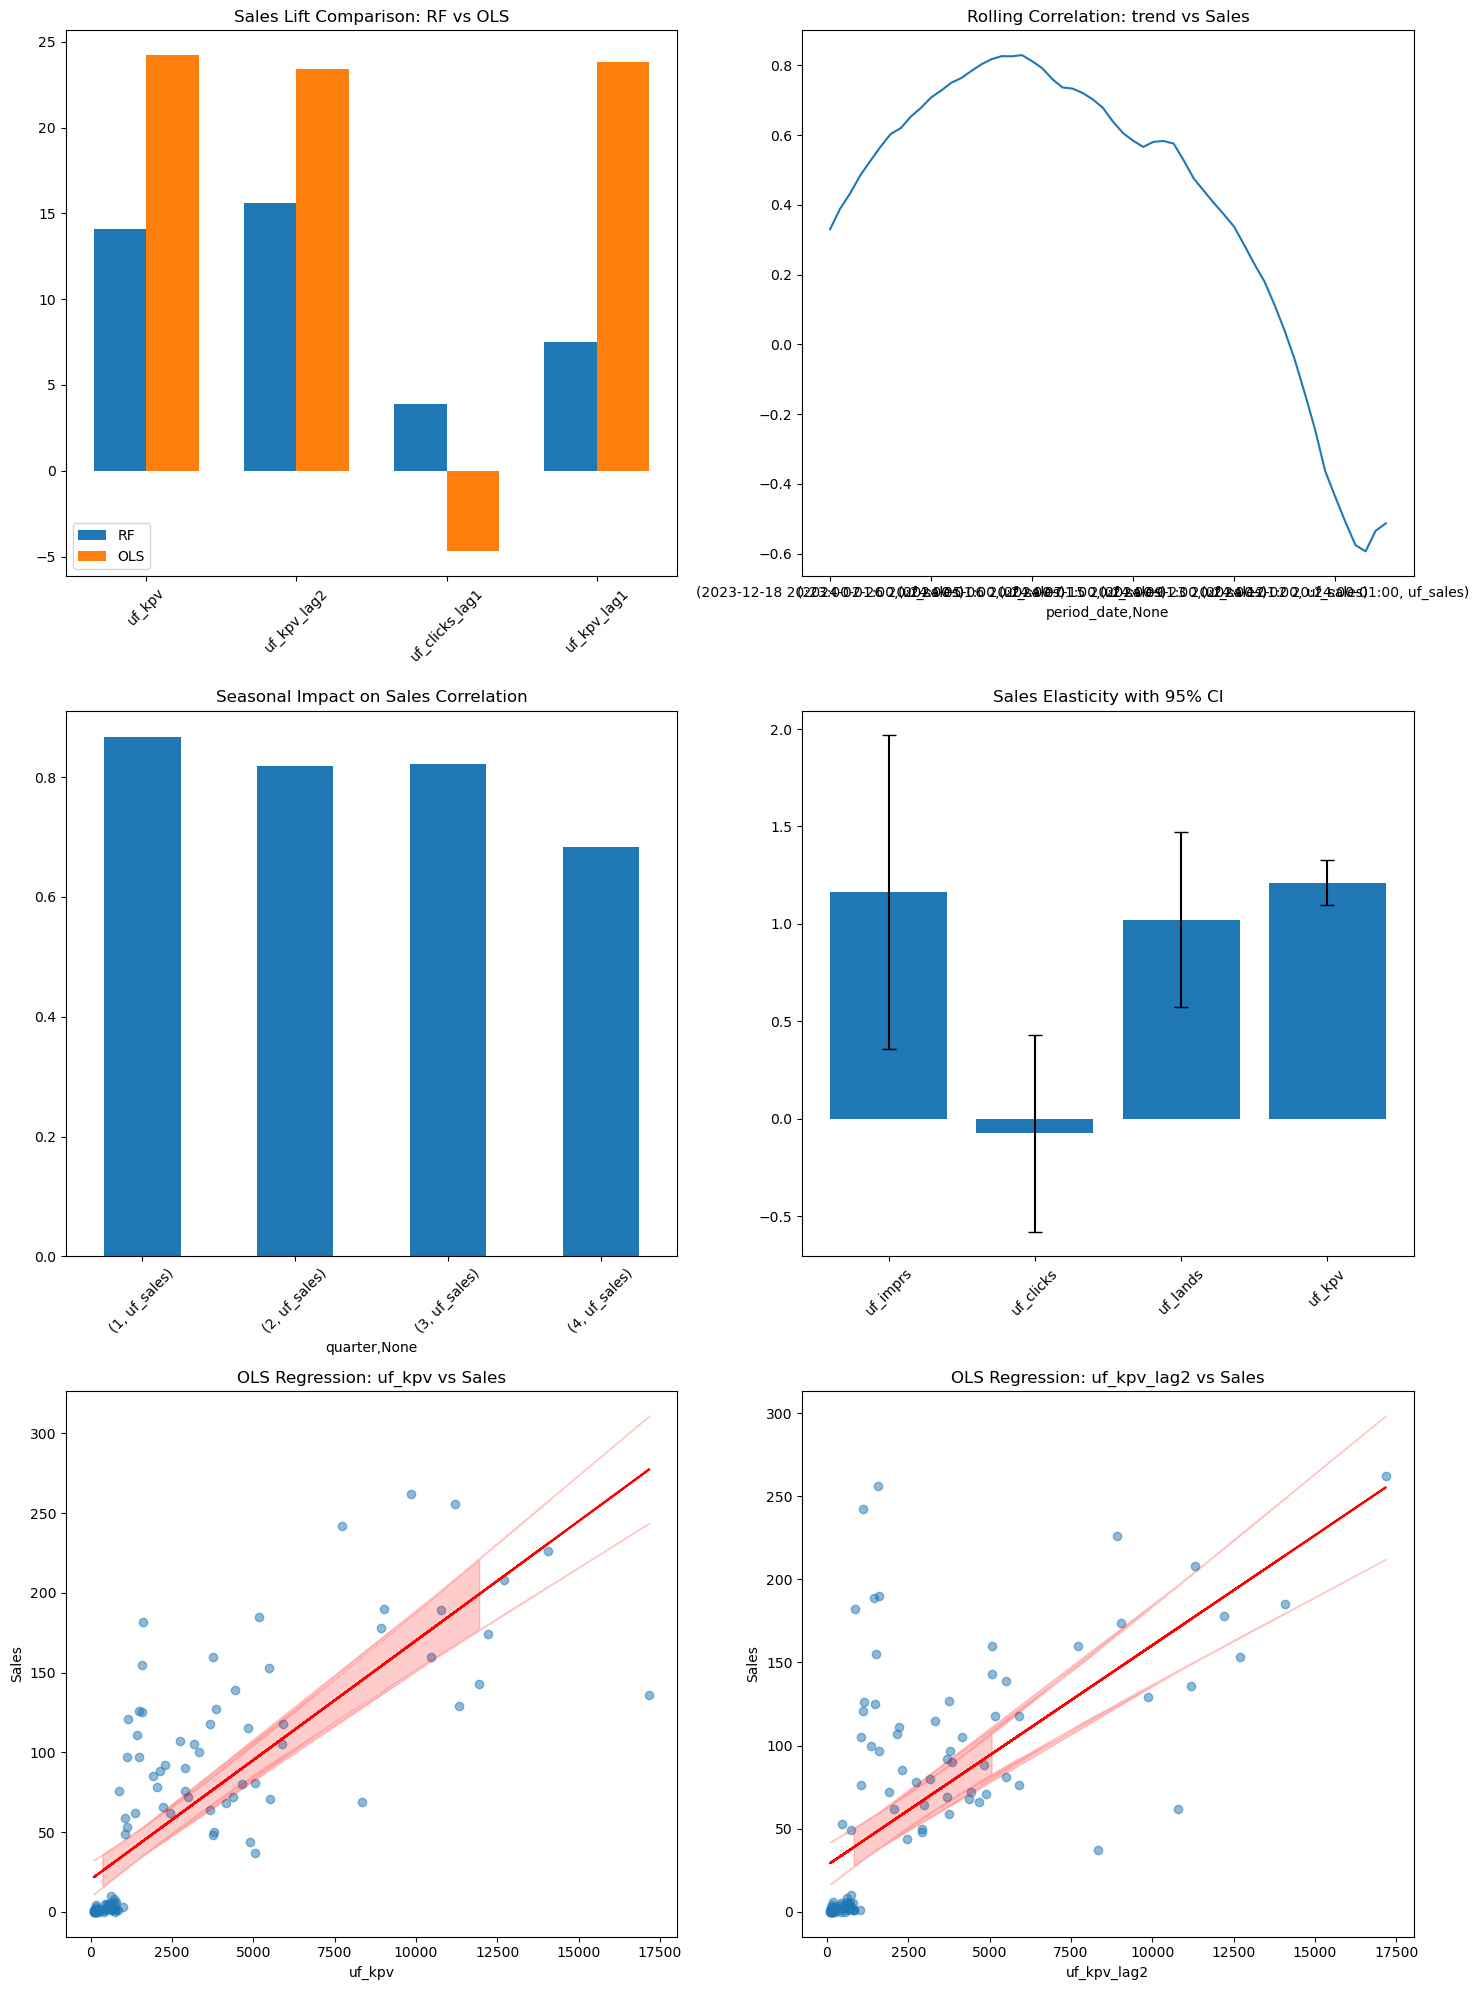


Analyzing M frequency...

Integrated Causal Impact Analysis:

Metric Impact Analysis (20% Increase):

uf_kpv:
------------------------------
Random Forest Results:
Average Lift: 3.45%
Lift Range: -0.17% to 25.90%

OLS Regression Results:
Coefficient: 0.017
P-value: 0.0000
R-squared: 0.698

Elasticity Analysis:
Elasticity: 1.348
Standard Error: 0.121
T-statistic: 11.169
P-value: 0.0000
R-squared: 0.850

uf_lands:
------------------------------
Random Forest Results:
Average Lift: 9.38%
Lift Range: -0.79% to 89.97%

OLS Regression Results:
Coefficient: 0.005
P-value: 0.0245
R-squared: 0.210

Elasticity Analysis:
Elasticity: 1.713
Standard Error: 0.565
T-statistic: 3.031
P-value: 0.0061
R-squared: 0.295

uf_kpv_rate:
------------------------------
Random Forest Results:
Average Lift: 0.67%
Lift Range: -5.16% to 20.22%

OLS Regression Results:
Coefficient: 792.764
P-value: 0.0004
R-squared: 0.437

Elasticity Analysis:
Elasticity: 8.910
Standard Error: 1.491
T-statistic: 5.975
P-value: 0.0

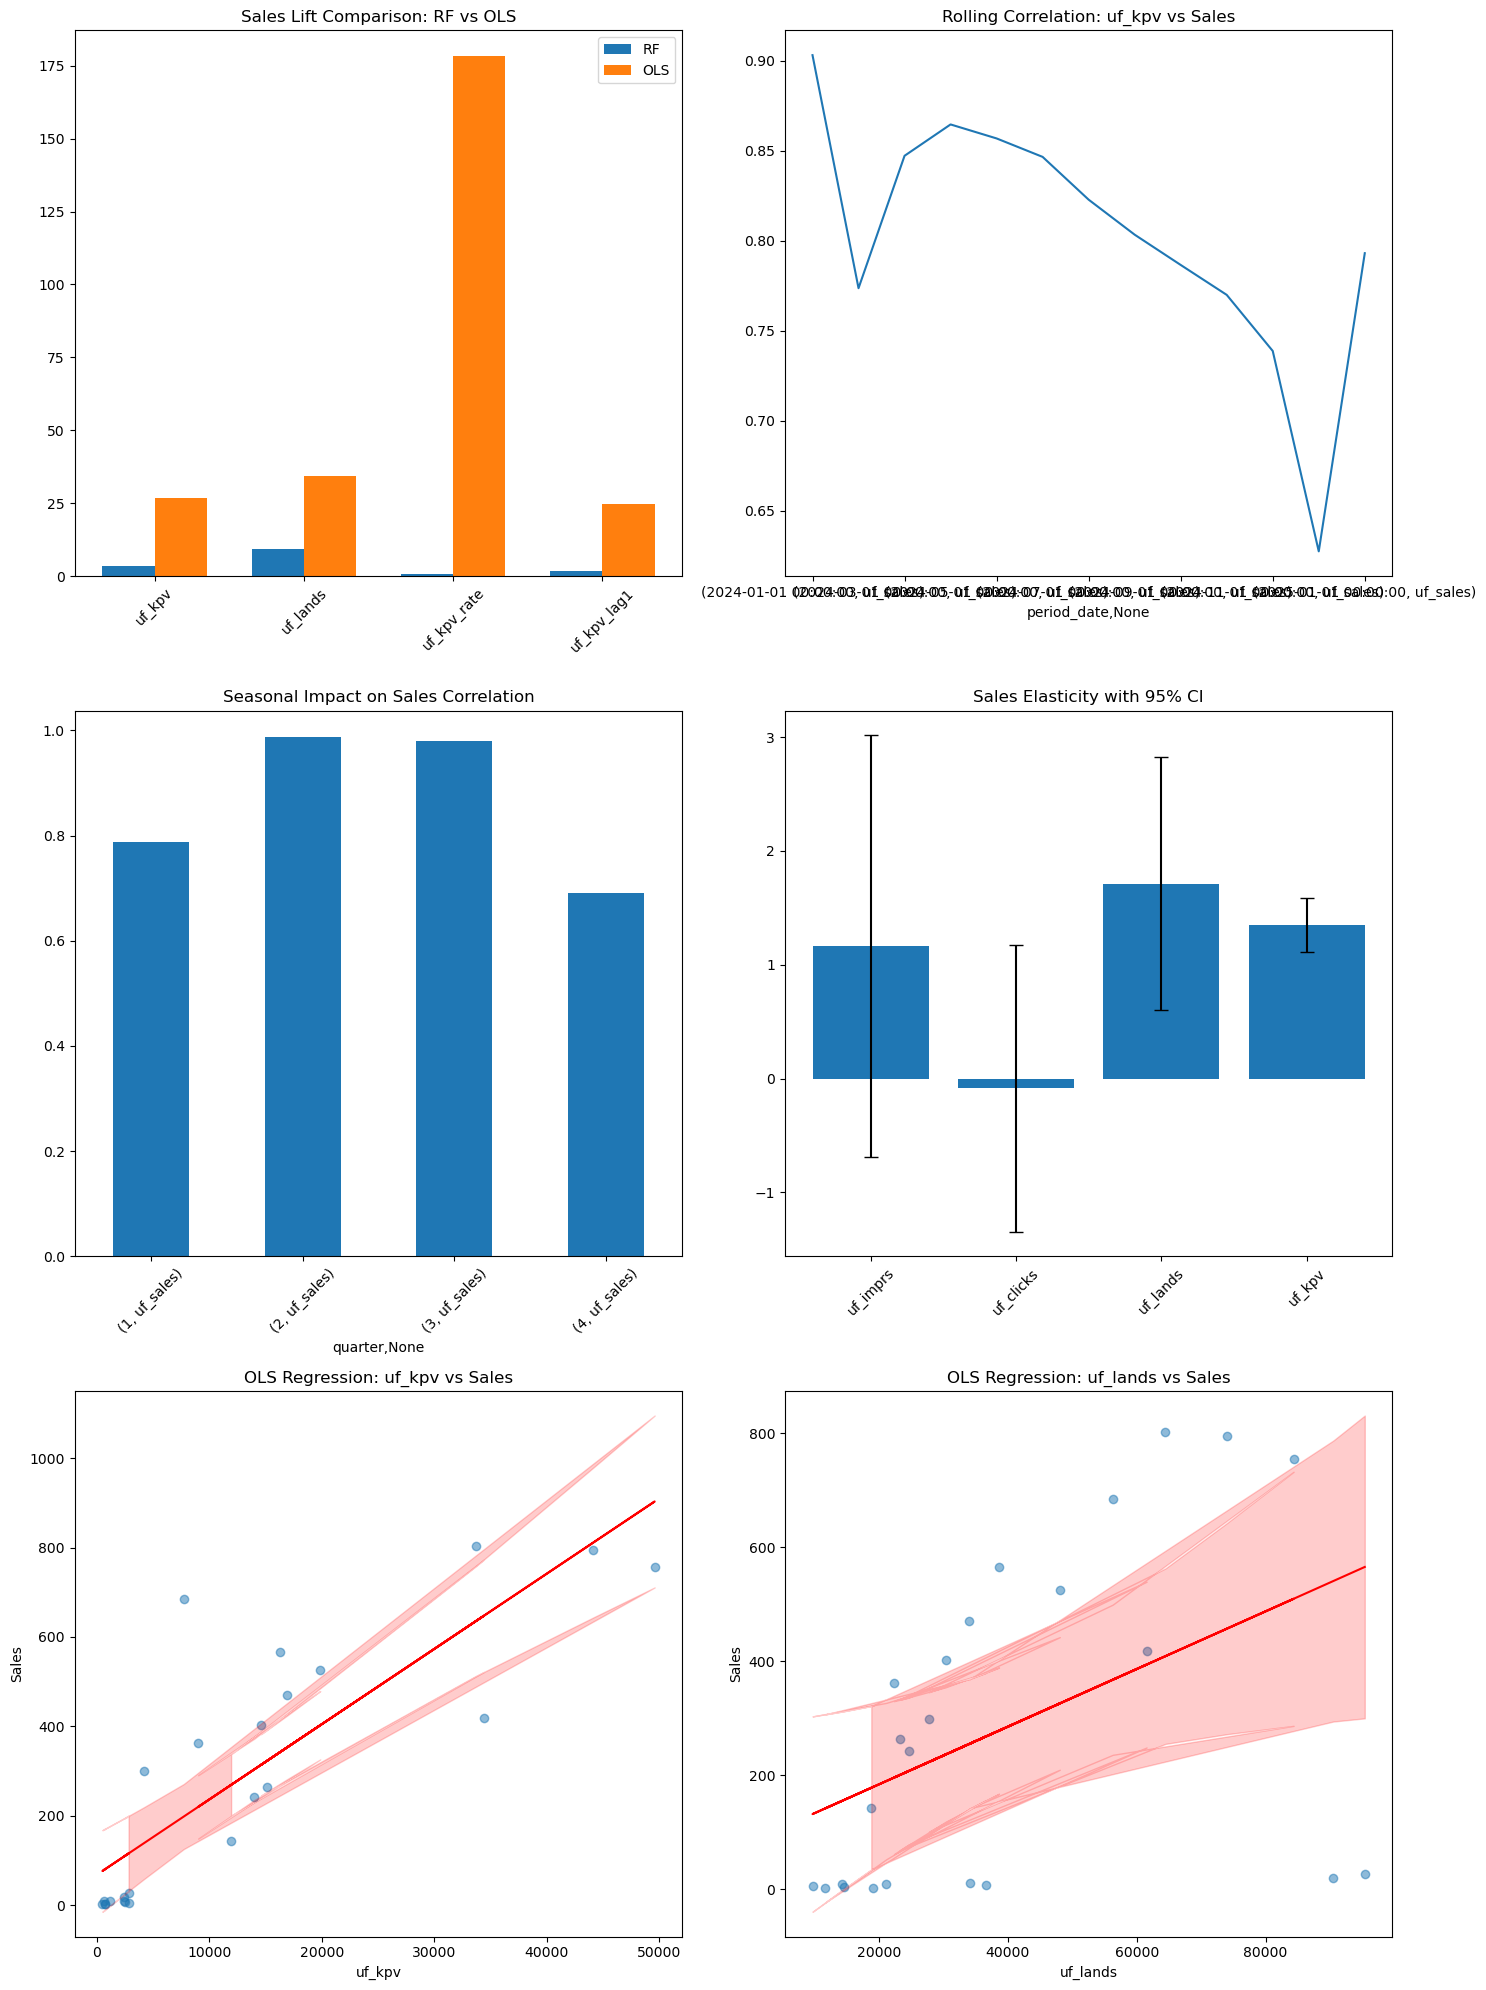

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def prepare_time_series_data(df, frequency='W'):
    """
    Prepare time series data for either weekly or monthly analysis
    """
    df['date'] = pd.to_datetime(df['date'])
    
    # monthly weekly group
    if frequency == 'M':
        df['period_date'] = df['date'].dt.to_period('M').astype(str) + '-01'
    else:
        df['period_date'] = df['date'].dt.to_period('W').astype(str) + '-1'
    
    df['period_date'] = pd.to_datetime(df['period_date'])
    
    # agg period
    agg_df = df.groupby(['period_date']).agg({
        'uf_imprs': 'sum',
        'uf_clicks': 'sum',
        'uf_lands': 'sum',
        'uf_kpv': 'sum',
        'uf_sales': 'sum'
    }).reset_index()
    
    agg_df = agg_df.set_index('period_date')
    
    # lags
    metrics = ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv']
    lag_periods = 3 if frequency == 'M' else 4
    
    for metric in metrics:
        for lag in range(1, lag_periods + 1):
            agg_df[f'{metric}_lag{lag}'] = agg_df[metric].shift(lag)
        
        # rates
        if metric != 'uf_imprs':
            prev_metric = metrics[metrics.index(metric) - 1]
            agg_df[f'{metric}_rate'] = agg_df[metric] / agg_df[prev_metric].replace(0, np.nan)
    
    # seasonality features
    agg_df['month'] = agg_df.index.month
    agg_df['quarter'] = agg_df.index.quarter
    
    # trend
    agg_df['trend'] = np.arange(len(agg_df))
    agg_df = agg_df.dropna()
    
    return agg_df

def analyze_and_compare(df):
    """
    Analyze and compare weekly vs monthly patterns
    """
    results = {}
    
    for frequency in ['W', 'M']:

        prepared_df = prepare_time_series_data(df, frequency)
        
        # corrs
        correlations = prepared_df.corr()
        
        # RF
        rf_importance, rf_model = run_random_forest_analysis(prepared_df)
        
        # GC
        granger_results = {}
        for col in ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv']:
            try:
                granger = grangercausalitytests(
                    prepared_df[['uf_sales', col]], 
                    maxlag=4, 
                    verbose=False
                )
                granger_results[col] = min([test[0]['ssr_chi2test'][1] 
                                          for test in granger.values()])
            except:
                granger_results[col] = np.nan
        
        # results
        results[frequency] = {
            'data': prepared_df,
            'correlations': correlations,
            'rf_importance': rf_importance,
            'rf_model': rf_model,
            'granger_causality': granger_results
        }
    
    return results

def run_random_forest_analysis(df):
    """
    Run Random Forest analysis and return feature importance
    """
    # x y split
    X = df.drop(['uf_sales'], axis=1)
    y = df['uf_sales']
    
    # fit RF
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # feat importance
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return importance, rf

def run_ols_analysis(df, metric):
    """
    Run OLS regression analysis for a given metric
    """
    # x y split
    X = df[metric]
    y = df['uf_sales']
    X = sm.add_constant(X)
    
    # fit
    model = sm.OLS(y, X).fit()
    
    # pred values and CI
    predictions = model.predict(X)
    pred_ci = model.get_prediction(X).conf_int()
    
    return {
        'model': model,
        'predictions': predictions,
        'confidence_intervals': pred_ci,
        'summary': model.summary()
    }

def calculate_elasticity_with_inference(df, metric):
    """
    Calculate elasticity with additional statistical inference
    """
    # Log transformation -
    log_sales = np.log(df['uf_sales'] + 1)
    log_metric = np.log(df[metric] + 1)
    
    # OLS for elastic
    X = sm.add_constant(log_metric)
    model = sm.OLS(log_sales, X).fit()
    
    # stats
    elasticity = model.params[1]
    std_err = model.bse[1]
    t_stat = model.tvalues[1]
    p_value = model.pvalues[1]
    r_squared = model.rsquared
    
    return {
        'elasticity': elasticity,
        'std_err': std_err,
        't_stat': t_stat,
        'p_value': p_value,
        'r_squared': r_squared,
        'model': model
    }

def run_causal_inference_analysis(df, results, frequency='W'):
    """
    Integrated causal inference analysis combining RF and OLS approaches
    """
    # RF top feats
    top_features = results[frequency]['rf_importance'].head(5)['feature'].tolist()
    
    # scenarios
    baseline_df = df.copy()
    scenarios = {}
    
    for feature in top_features:
        if feature in ['month', 'quarter', 'trend']:  # Skip non-UF metrics
            continue
            
        # Analysis
        # RF
        intervention_df = df.copy()
        intervention_df[feature] = intervention_df[feature] * 1.2
        
        baseline_pred = results[frequency]['rf_model'].predict(baseline_df.drop('uf_sales', axis=1))
        intervention_pred = results[frequency]['rf_model'].predict(intervention_df.drop('uf_sales', axis=1))
        
        rf_lift = (intervention_pred - baseline_pred) / baseline_pred * 100
        
        # OLS 
        ols_results = run_ols_analysis(df, feature)
        elasticity_results = calculate_elasticity_with_inference(df, feature)
        
        scenarios[feature] = {
            'rf_baseline': baseline_pred,
            'rf_intervention': intervention_pred,
            'rf_lift': rf_lift,
            'rf_avg_lift': np.mean(rf_lift),
            'ols_results': ols_results,
            'elasticity_results': elasticity_results
        }
    
    return scenarios

def analyze_temporal_patterns(df, metric, frequency='W'):
    """
    Analyze temporal patterns in the relationship between metric and sales
    """
    # rolling corrs
    window = 12 if frequency == 'M' else 52
    rolling_corr = df[['uf_sales', metric]].rolling(window=window).corr()
    rolling_corr = rolling_corr.loc[(slice(None), 'uf_sales'), metric]
    
    # seasonal patterns
    seasonal_df = df.groupby('quarter')[[metric, 'uf_sales']].corr()
    seasonal_impact = seasonal_df.loc[(slice(None), 'uf_sales'), metric]
    
    return {
        'rolling_correlation': rolling_corr,
        'seasonal_impact': seasonal_impact
    }

def plot_integrated_insights(results, scenarios, frequency='W'):
    """
    Create visualizations combining RF and OLS insights
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    
    # RF vs OLS Lifts
    rf_lifts = {k: v['rf_avg_lift'] for k, v in scenarios.items()}
    ols_lifts = {k: v['elasticity_results']['elasticity'] * 20 for k, v in scenarios.items()}  # 20% increase
    
    x = np.arange(len(rf_lifts))
    width = 0.35
    
    axes[0,0].bar(x - width/2, rf_lifts.values(), width, label='RF')
    axes[0,0].bar(x + width/2, ols_lifts.values(), width, label='OLS')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(rf_lifts.keys(), rotation=45)
    axes[0,0].set_title('Sales Lift Comparison: RF vs OLS')
    axes[0,0].legend()
    
    # Rolling Impact
    df = results[frequency]['data']
    top_metric = results[frequency]['rf_importance'].iloc[0]['feature']
    temporal = analyze_temporal_patterns(df, top_metric, frequency)
    temporal['rolling_correlation'].dropna().plot(ax=axes[0,1])
    axes[0,1].set_title(f'Rolling Correlation: {top_metric} vs Sales')
    
    # Seasonal patterns
    temporal['seasonal_impact'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Seasonal Impact on Sales Correlation')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # CI elastic
    elasticities = {}
    conf_intervals = {}
    
    for metric in ['uf_imprs', 'uf_clicks', 'uf_lands', 'uf_kpv']:
        try:
            results = calculate_elasticity_with_inference(df, metric)
            elasticities[metric] = results['elasticity']
            conf_intervals[metric] = [
                results['elasticity'] - 1.96 * results['std_err'],
                results['elasticity'] + 1.96 * results['std_err']
            ]
        except:
            elasticities[metric] = np.nan
            conf_intervals[metric] = [np.nan, np.nan]
    
    metrics = list(elasticities.keys())
    values = list(elasticities.values())
    errors = [
        [v - conf_intervals[m][0] for m, v in elasticities.items()],
        [conf_intervals[m][1] - v for m, v in elasticities.items()]
    ]
    
    axes[1,1].bar(metrics, values)
    axes[1,1].errorbar(metrics, values, yerr=errors, fmt='none', color='black', capsize=5)
    axes[1,1].set_title('Sales Elasticity with 95% CI')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # OLS reg plots top 2
    top_metrics = list(rf_lifts.keys())[:2]
    for i, metric in enumerate(top_metrics):
        try:
            ols_results = scenarios[metric]['ols_results']
            axes[2,i].scatter(df[metric], df['uf_sales'], alpha=0.5)
            axes[2,i].plot(df[metric], ols_results['predictions'], color='red')
            axes[2,i].fill_between(
                df[metric],
                ols_results['confidence_intervals'][:,0],
                ols_results['confidence_intervals'][:,1],
                alpha=0.2, color='red'
            )
            axes[2,i].set_title(f'OLS Regression: {metric} vs Sales')
            axes[2,i].set_xlabel(metric)
            axes[2,i].set_ylabel('Sales')
        except Exception as e:
            axes[2,i].text(0.5, 0.5, f'Unable to plot OLS for {metric}\n{str(e)}',
                          ha='center', va='center')
    
    plt.tight_layout()
    return fig

def print_integrated_insights(scenarios, results, frequency='W'):
    """
    Print detailed insights combining RF and OLS results
    """
    print("\nIntegrated Causal Impact Analysis:")
    print("=" * 50)
    
    # RF and OLS results
    print("\nMetric Impact Analysis (20% Increase):")
    for metric, scenario in scenarios.items():
        print(f"\n{metric}:")
        print("-" * 30)
        
        # RF 
        print("Random Forest Results:")
        print(f"Average Lift: {scenario['rf_avg_lift']:.2f}%")
        print(f"Lift Range: {np.min(scenario['rf_lift']):.2f}% to {np.max(scenario['rf_lift']):.2f}%")
        
        # OLS 
        print("\nOLS Regression Results:")
        ols_model = scenario['ols_results']['model']
        print(f"Coefficient: {ols_model.params[1]:.3f}")
        print(f"P-value: {ols_model.pvalues[1]:.4f}")
        print(f"R-squared: {ols_model.rsquared:.3f}")
        
        # Elasticity 
        elasticity = scenario['elasticity_results']
        print("\nElasticity Analysis:")
        print(f"Elasticity: {elasticity['elasticity']:.3f}")
        print(f"Standard Error: {elasticity['std_err']:.3f}")
        print(f"T-statistic: {elasticity['t_stat']:.3f}")
        print(f"P-value: {elasticity['p_value']:.4f}")
        print(f"R-squared: {elasticity['r_squared']:.3f}")
    
    # RF feat importance
    print("\nRandom Forest Feature Importance:")
    print("-" * 30)
    for _, row in results[frequency]['rf_importance'].head().iterrows():
        print(f"{row['feature']}: {row['importance']:.3f}")
    
    # Temporal stats
    try:
        top_metric = results[frequency]['rf_importance'].iloc[0]['feature']
        temporal = analyze_temporal_patterns(results[frequency]['data'], top_metric, frequency)
        print(f"\nSeasonal Impact Analysis for {top_metric}:")
        print("-" * 30)
        print(temporal['seasonal_impact'])
    except Exception as e:
        print(f"\nUnable to calculate temporal patterns: {str(e)}")

def summarize_integrated_evidence(results, scenarios, frequency='W'):
    """
    Provide comprehensive summary of all evidence
    """
    print(f"\nComprehensive Analysis Summary ({frequency}):")
    print("=" * 50)
    
    # Compare models
    print("\n1. Model Performance Comparison:")
    for metric, scenario in scenarios.items():
        rf_rmse = np.sqrt(np.mean((scenario['rf_baseline'] - results[frequency]['data']['uf_sales'])**2))
        ols_rmse = np.sqrt(np.mean((scenario['ols_results']['predictions'] - results[frequency]['data']['uf_sales'])**2))
        
        print(f"\n{metric}:")
        print(f"RF RMSE: {rf_rmse:.2f}")
        print(f"OLS RMSE: {ols_rmse:.2f}")
        print(f"RF R-squared: {results[frequency]['rf_model'].score(results[frequency]['data'].drop('uf_sales', axis=1), results[frequency]['data']['uf_sales']):.3f}")
        print(f"OLS R-squared: {scenario['ols_results']['model'].rsquared:.3f}")
    
    # Causality Evidence
    print("\n2. Causality Evidence:")
    for metric, scenario in scenarios.items():
        print(f"\n{metric}:")
        # Granger causality
        granger_p = results[frequency]['granger_causality'].get(metric, np.nan)
        print(f"Granger Causality p-value: {granger_p:.4f}")
        # OLS significance
        ols_p = scenario['ols_results']['model'].pvalues[1]
        print(f"OLS p-value: {ols_p:.4f}")
        # Combined
        if granger_p < 0.05 and ols_p < 0.05:
            strength = "Strong"
        elif granger_p < 0.05 or ols_p < 0.05:
            strength = "Moderate"
        else:
            strength = "Weak"
        print(f"Causal Evidence Strength: {strength}")
    
    # Impact Estimates
    print("\n3. Impact Estimates (20% Increase):")
    for metric, scenario in scenarios.items():
        print(f"\n{metric}:")
        print(f"RF Estimate: {scenario['rf_avg_lift']:.2f}%")
        print(f"OLS Estimate: {scenario['elasticity_results']['elasticity'] * 20:.2f}%")
        
        # Confidence 
        rf_std = np.std(scenario['rf_lift'])
        ols_std = scenario['elasticity_results']['std_err'] * 20
        print(f"RF Uncertainty: ±{rf_std:.2f}%")
        print(f"OLS Uncertainty: ±{ols_std:.2f}%")

def main():
    """
    Main execution function
    """
    # Load data
    print("Loading data...")
    df = pd.read_csv("ccl_raw_sales_data_daily2.csv")
    
    # Run
    print("Running analysis...")
    results = analyze_and_compare(df)
    for freq in ['W', 'M']:
        print(f"\nAnalyzing {freq} frequency...")
        prepared_df = results[freq]['data']
        scenarios = run_causal_inference_analysis(prepared_df, results, freq)
        results[freq]['scenarios'] = scenarios
        
        # stats
        print_integrated_insights(scenarios, results, freq)
        summarize_integrated_evidence(results, scenarios, freq)
        
        # plots
        fig = plot_integrated_insights(results, scenarios, freq)
        plt.show()
    
    return results

if __name__ == "__main__":
    results = main()
